# Task 1

Using Euler Discretization method to derive the discrete process model from the continuous time system model \\
# Continuous Process Model 
$ \dot{x}(t) = A \cdot x(t) + B \cdot u(t) + N(t) $ 
# Discrete Process Model
$ x_t = F \cdot x_{t-1} + G \cdot u_t + Q $

# Task 2

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import pandas as pd

In [64]:
import numpy as np

class Dataloader:
    def __init__(self):
        '''
        Initialize the data loader for the quadrotor data set extracting the time, control inputs and state measurements
        '''
        self.t = None
        self.u = None
        self.z = None

    def load(self, filename):
        '''
        Load the data from the given txt files and store the time, control inputs and state measurements
        '''
        quadrotor_data = pd.read_csv(filename, header=None).values  # Assuming no header
        self.t = quadrotor_data[:, 0] # Time is the first column
        self.u = quadrotor_data[:, 1:4] # control inputs are the next 3 columns
        self.z = quadrotor_data[:, 4:7] # state measurements are the last 3 columns
        print(f"Data loaded from {filename}")
        return self.t, self.u, self.z


In [71]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class KalmanFilter:
    def __init__(self, t, u, z):
        '''
        Initialize the Kalman filter with the time, control inputs and state measurements, and the initial state and covariance matrix
        '''
        self.t = t
        self.u = u
        self.z = z
        self.xhat = None
        self.P = None

    def predict(self, xhat_k_minus_1, P_k_minus_1, A, Q, G, u_k_minus_1, m):
        '''
        Predict the state and covariance matrix at the next time step
        Inputs: xhat_k_minus_1 - State estimate at time k-1
                P_k_minus_1 - Covariance matrix at time k-1
                A - State transition matrix
                Q - Process noise covariance matrix
                G - Control input matrix
                u_k_minus_1 - Control input at time k-1
                m - Mass of the quadrotor
        Outputs: xhat_pred - Predicted state estimate at time k
                    P_pred - Predicted covariance matrix at time k
        '''
        dt = self.t[1] - self.t[0]  # Assuming constant time step for simplicity
        # A = np.eye(A.shape[0]) + dt * A
        xhat_pred = A @ xhat_k_minus_1 + G @ u_k_minus_1 * m # Predicted state estimate
        P_pred = A @ P_k_minus_1 @ A.T + Q # Predicted covariance matrix
        return xhat_pred, P_pred

    def update(self, xhat_pred, P_pred, H, R, z_k):
        '''
        Update the state and covariance matrix based on the measurement at the current time step
        Inputs: xhat_pred - Predicted state estimate at time k
                P_pred - Predicted covariance matrix at time k
                H - Measurement matrix
                R - Measurement noise covariance matrix
                z_k - Measurement at time k
        Outputs: xhat_k - Updated state estimate at time k
                P_k - Updated covariance matrix at time k
        '''
        S = H @ P_pred @ H.T + R # Innovation covariance
        K = P_pred @ H.T @ np.linalg.inv(S) # Kalman gain
        y = z_k - H @ xhat_pred # Innovation
        xhat_k = xhat_pred + K @ y # Updated state estimate
        P_k = (np.eye(K.shape[0]) - K @ H) @ P_pred # Updated covariance matrix
        return xhat_k, P_k

    def run_filter(self, H, R, Q, param, m=0.027):
        '''
        Run the Kalman filter for the given data and system matrices
        Inputs: H - Measurement matrix
                R - Measurement noise covariance matrix
                Q - Process noise covariance matrix
                param - 'pos' if the filter is to be run for position estimation, 'vel' if the filter is to be run for velocity estimation
                m - Mass of the quadrotor
        '''
        n = len(self.t) # Number of time steps
        self.xhat = np.zeros((n, 6)) # State estimate at each time step
        self.P = np.zeros((n, 6, 6)) # Covariance matrix at each time step
        A, G = self._get_system_matrices() # Get the state transition matrix and control input matrix

        # Initialization
        if param == 'pos':
            self.xhat[0] = np.concatenate([self.z[0], np.zeros(3)]) # Initialize the state estimate with the first measurement
        elif param == 'vel':
            self.xhat[0] = np.concatenate([np.zeros(3), self.z[0]]) 

        self.P[0] = np.diag([0.1, 0.1, 0.1, 0.05, 0.05, 0.05])

        for k in range(1, n):
            self.xhat[k-1], self.P[k-1] = self.predict(self.xhat[k-1], self.P[k-1], A, Q, G, self.u[k-1], m) # Prediction step
            self.xhat[k], self.P[k] = self.update(self.xhat[k-1], self.P[k-1], H, R, self.z[k]) # Update step

    def _get_system_matrices(self):
        '''
        Get the state transition matrix and control input matrix
        '''
        dt = self.t[1] - self.t[0]
        A = np.array([[1, 0, 0, dt, 0, 0],
                      [0, 1, 0, 0, dt, 0],
                      [0, 0, 1, 0, 0, dt],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]])
        G = np.array([[dt**2/2, 0, 0],
                      [0, dt**2/2, 0],
                      [0, 0, dt**2/2],
                      [dt, 0, 0],
                      [0, dt, 0],
                      [0, 0, dt]])
        return A, G

    def plot_results(self):
        '''
        Plot the results after running the Kalman filter
        '''
        if self.xhat is None:
            print("Data not yet filtered. Run the filter first.")
            return
        # Extract estimated positions
        p_hat = self.xhat[:, :3]

        # Plot estimated path
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(p_hat[:, 0], p_hat[:, 1], p_hat[:, 2])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Estimated trajectory')
        plt.show()

    def plot_results_with_actual_path(self, actual_path_file):
        '''
        Plot the results after running the Kalman filter along with the actual path
        Inputs: actual_path_file - Path to the file containing the actual path data
        '''
        if self.xhat is None:
            print("Data not yet filtered. Run the filter first.")
            return
        
        # Load actual path data
        data = pd.read_csv(actual_path_file)
        x_actual = data.iloc[:, -3]
        y_actual = data.iloc[:, -2]
        z_actual = data.iloc[:, -1]

        # Extract estimated positions
        p_hat = self.xhat[:, :3]

        # Plot estimated path
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(p_hat[:, 0], p_hat[:, 1], p_hat[:, 2], label='Estimated Path')

        # Plot actual path
        ax.scatter(x_actual, y_actual, z_actual, color='r', label='Actual Path')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        ax.set_title('Estimated trajectory vs Actual trajectory')

        plt.show()

Data loaded from Data/kalman_filter_data_mocap.txt


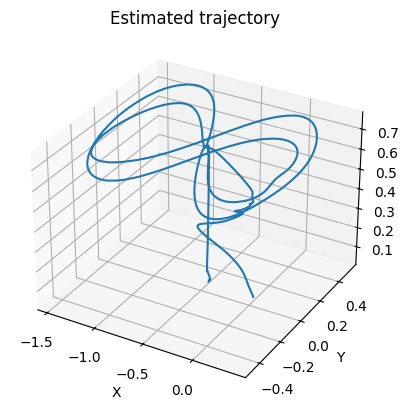

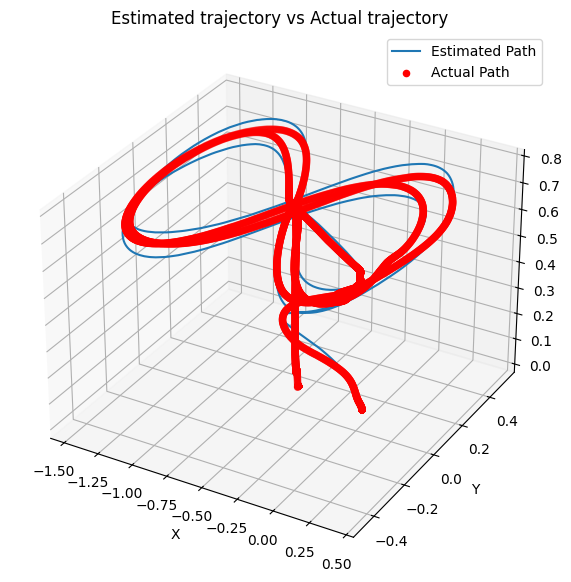

In [67]:
# Load data
dataloader = Dataloader()
t, u, z = dataloader.load("Data/kalman_filter_data_mocap.txt")

# Initialize and run Kalman Filter
kf = KalmanFilter(t, u, z)
H = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])
R = np.ones((3, 3))
Q = np.diag([0.01, 0.01, 0.01, 0.001, 0.001, 0.001])
kf.run_filter(H, R, Q, 'pos')
kf.plot_results()
kf.plot_results_with_actual_path("Data/kalman_filter_data_mocap.txt")

Data loaded from Data/kalman_filter_data_low_noise.txt


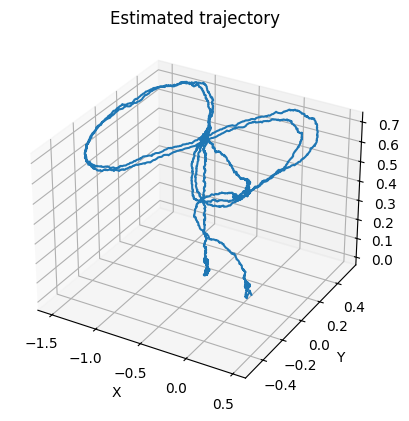

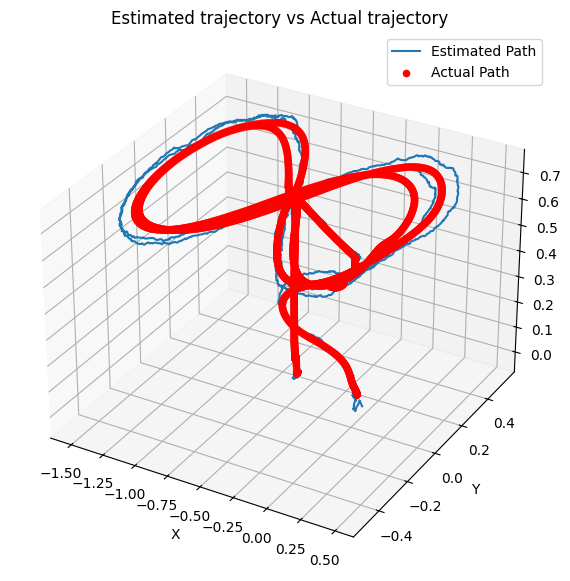

In [68]:
# Initialize the data loader
dataloader = Dataloader()

# Load the data
t, u, z = dataloader.load('Data/kalman_filter_data_low_noise.txt')

# Initialize the Kalman Filter
kf = KalmanFilter(t, u, z)

# Set the measurement matrix, process noise covariance, and measurement noise covariance
H = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])
Q = np.diag([0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001])  # Smaller process noise
R = np.diag([0.2, 0.2, 0.2])  # Larger measurement noise

# Run the filter
kf.run_filter(H, R, Q, 'pos')
# Plot the estimated positions
kf.plot_results()
kf.plot_results_with_actual_path("Data/kalman_filter_data_mocap.txt")

Data loaded from Data/kalman_filter_data_high_noise.txt


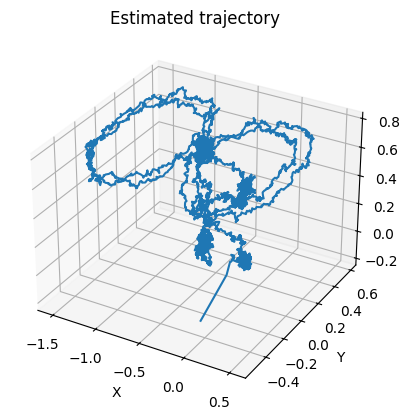

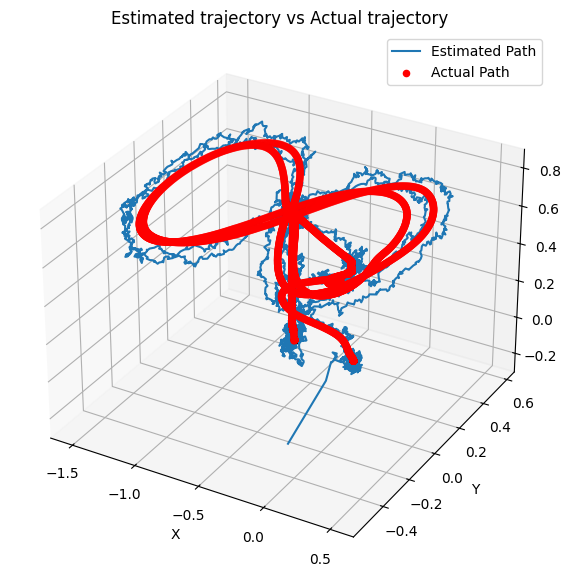

In [69]:
# Initialize the data loader
dataloader = Dataloader()

# Load the data
t, u, z = dataloader.load('Data/kalman_filter_data_high_noise.txt')

# Initialize the Kalman Filter
kf = KalmanFilter(t, u, z)

# Set the measurement matrix, process noise covariance, and measurement noise covariance
H = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])
Q = np.diag([0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001])  # Smaller process noise
R = np.diag([0.2, 0.2, 0.2])  # Larger measurement noise

# Run the filter
kf.run_filter(H, R, Q, 'pos')
# Plot the estimated positions
kf.plot_results()
kf.plot_results_with_actual_path("Data/kalman_filter_data_mocap.txt")

Data loaded from Data/kalman_filter_data_velocity.txt


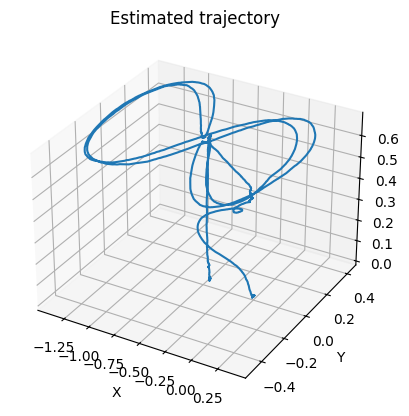

In [70]:
# Load velocity data
file_path_velocity = 'Data/kalman_filter_data_velocity.txt'
dataloader_velocity = Dataloader()
t_velocity, u_velocity, z_velocity = dataloader_velocity.load(file_path_velocity)

# Initialize the Kalman Filter for velocity data
kf_velocity = KalmanFilter(t_velocity, u_velocity, z_velocity)

# Set the measurement matrix, process noise covariance, and measurement noise covariance for velocity data
H_velocity = np.array([[0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
Q_velocity = np.diag([0.001, 0.001, 0.001, 0.001, 0.001, 0.001])  # Process noise covariance (tune these values)
R_velocity = np.diag([0.5, 0.5, 0.5])

# Run the Kalman filter for velocity data
kf_velocity.run_filter(H_velocity, R_velocity, Q_velocity, 'vel')

# Plot the estimated positions for velocity data
kf_velocity.plot_results()